# Inference on Bayesian Network

## Load Data, Create DAG

In [1]:
library("gRain")
library("Rgraphviz")
library("dagitty")
library("combinat")

options(warn=-1)
#   setwd("/Users/apple1/Dropbox/Uni/Nijmegen/WS17_18/BN")
#setwd("D:/RU/Sem1/Bayesian Networks/Project")
setwd("/Users/lisa/Documents/Uni/03.SemesterMaster/BN/bn17")
# setwd("C:/Users/Valentin/Uni/RU/Sem1/Bayesian Networks")

Loading required package: gRbase
Loading required package: graph
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min

Loading required pack

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,native.country,income
2,5,2,2,0,0,0,3,0,0
3,1,2,0,0,0,0,0,0,0
2,0,1,1,1,0,0,3,0,0
4,0,1,0,1,4,0,3,0,0
1,0,2,0,3,4,1,3,1,0
2,0,3,0,0,0,1,3,0,0


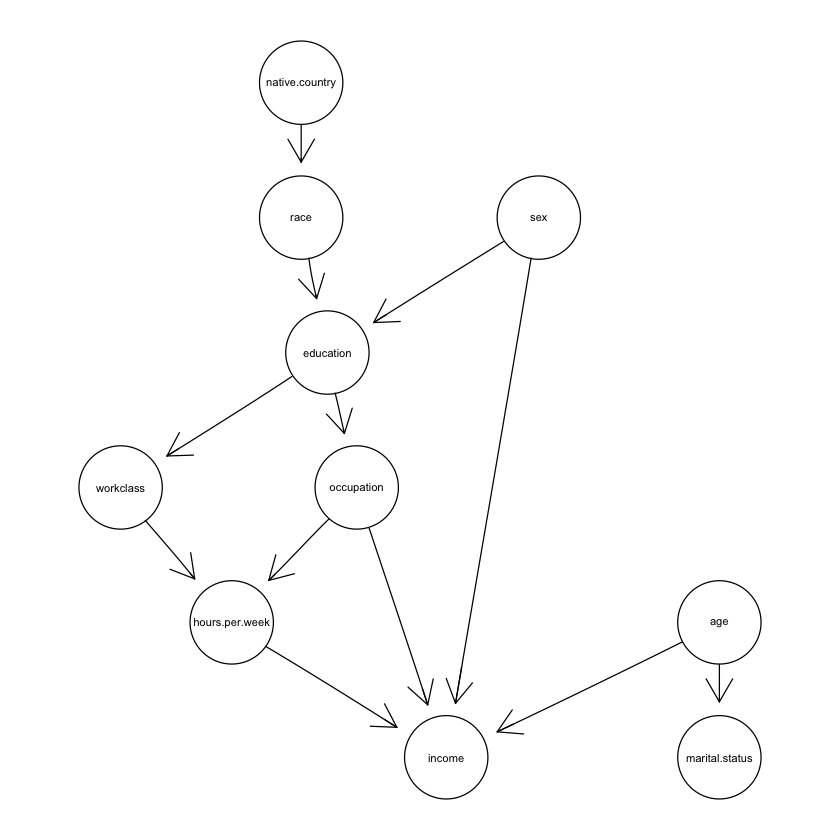

In [3]:
data <- read.table(header=T, sep=",", 'adult_cleaned.csv')

our_network <- dag(~ race:native.country + education:race:sex + workclass:education + hours.per.week:workclass:occupation + occupation:education + marital.status:age + income:age:sex:occupation:hours.per.week)
plot(our_network)
head(data)

data[data=="?"]<-NA
data<-data[complete.cases(data),]

## Implied independencies

In [332]:
g <- dagitty( "dag{ native.country -> race -> education -> occupation -> hours.per.week -> income; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; age -> income; age -> marital.status}" )
independencies <- impliedConditionalIndependencies( g )
print(independencies)
print(length(independencies))

age _||_ education
age _||_ hours.per.week
age _||_ native.country
age _||_ occupation
age _||_ race
age _||_ sex
age _||_ workclass
education _||_ hours.per.week | occupation, workclass
education _||_ income | hours.per.week, occupation, sex
education _||_ income | occupation, sex, workclass
education _||_ marital.status
education _||_ native.country | race
hours.per.week _||_ marital.status
hours.per.week _||_ native.country | race
hours.per.week _||_ native.country | education
hours.per.week _||_ native.country | occupation, workclass
hours.per.week _||_ race | education
hours.per.week _||_ race | occupation, workclass
hours.per.week _||_ sex | education
hours.per.week _||_ sex | occupation, workclass
income _||_ marital.status | age
income _||_ native.country | race
income _||_ native.country | education, sex
income _||_ native.country | occupation, sex, workclass
income _||_ native.country | hours.per.week, occupation, sex
income _||_ race | education, sex
income _||_ race | occup

## Test Independencies

In [18]:
test_network <- function(data, independencies, sig_threshold, calc_strength=F){
    num_test <- 0
    num_failed <- 0
    all <- length(data[,1])
    sig_results <- list()
    # Loop through all found independencies
    for(i in 1:length(independencies)){
        # Get variables and conditioning set
        indp <- independencies[i]
        xyz <- unlist(indp) 
        # If conditioning set is empty testing is easy
        if(length(xyz)==2){
            #Chi-square test rmsea correction to test for implied statistical independence
            tst <- chisq.test(data[,xyz[1]], data[,xyz[2]])
            res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(data) - 1)*tst$parameter),0))
            #If result is larger than 0.05 we reject the null hypothesis of the variables being independent
            if(res > sig_threshold){
                print(paste('test: ', xyz[1], ' and ', xyz[2]))
                print(res)
                num_failed <- num_failed + 1
                print('-----------------')
            }
            num_test <- num_test + 1
            sig_results <- append(sig_results,res)
        }
        # If conditioning set is not empty testing is more involved
        else{
            failed <- 0
            print(paste(c('test ', xyz[1], ' and ', xyz[2], 'given ', xyz[-(1:2)]), collapse=' '))
            # We have to test for independence given all possible value combinations
            # of the conditioning variables
            strata <- list()
            for(i in 1:length(xyz[-(1:2)])){
                    # Get values of variables sorted by frequency
                    strata[i] <- as.data.frame(sort(table(data[,xyz[2+i]]),decreasing=T))
            }
            # Get all possible combinations of values
            comb_strata = expand.grid(strata)
            visited <- 0
            idx <- 1
            l_res <- c()
            off_all <- 0.8
            # Test conditions until 80% of data was tested
            while(visited<off_all*all){
                # Get data given conditioning set
                subdata <- data[interaction(data[,xyz[-(1:2)]]) == interaction(comb_strata[idx,]),]
                x <- subdata[,xyz[1]]
                y <- subdata[,xyz[2]]
                
                visited <- visited + nrow(subdata)
                idx <- idx + 1
                num_test <- num_test + 1
                # Only test if enough data (unique values) is available
                if(length(unique(x)) < 2 || length(unique(y)) < 2){
                    next
                }
                tst <- chisq.test(x,y)
                res <- sqrt(max((tst$statistic - tst$parameter)/(( nrow(subdata) - 1)*tst$parameter),0))
                if(res > sig_threshold){
                    failed <- 1
                    print(paste(xyz[-(1:2)], ' = ', comb_strata[idx,]),max.levels=0)
                    print(res)

                }
                if(calc_strength){
                    res <- res * nrow(subdata)/(nrow(data)*off_all)
                }
                l_res <- c(l_res, res)
            }
            if(failed){
                    num_failed <- num_failed + 1
                    print('-----------------')
            }
            sig_results <- append(sig_results, list(l_res))
        }
    }
    
    print(paste('Number of tests = ', num_test, collapse=''))
    print(paste('Number of tested independencies = ',length(independencies),collapse=''))
    print(paste('Number of failed independencies = ', num_failed, collapse=''))
    
    return(sig_results)
}




In [338]:
sig_threshold <- 0.05 
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test:  age  and  hours.per.week"
[1] 0.07403111
[1] "-----------------"
[1] "test  education  and  hours.per.week given  occupation workclass"
[1] "occupation  =  5" "workclass  =  1" 
[1] 0.06275108
[1] "occupation  =  4" "workclass  =  2" 
[1] 0.05669727
[1] "-----------------"
[1] "test  education  and  income given  hours.per.week occupation sex"
[1] "hours.per.week  =  2" "occupation  =  1"     "sex  =  1"           
[1] 0.05570996
[1] "hours.per.week  =  3" "occupation  =  1"     "sex  =  1"           
[1] 0.0580566
[1] "hours.per.week  =  1" "occupation  =  2"     "sex  =  1"           
[1] 0.1284068
[1] "hours.per.week  =  2" "occupation  =  2"     "sex  =  1"           
[1] 0.09366923
[1] "hours.per.week  =  3" "occupation  =  2"     "sex  =  1"           
[1] 0.1034253
[1] "hours.per.week  =  4" "occupation  =  2"     "sex  =  1"           
[1] 0.06778869
[1] "hours.per.week  =  5" "occupation  =  2"     "sex  =  1"           
[1] 0.1150442
[1] "hours.per.week  =  6" "oc

#### Check rmsea-value distribution to determine cut-off
It can be seen that there is a large drop in frequency between the values 0.06 and 0.07. Therefore we set 0.06 as a significance threshold

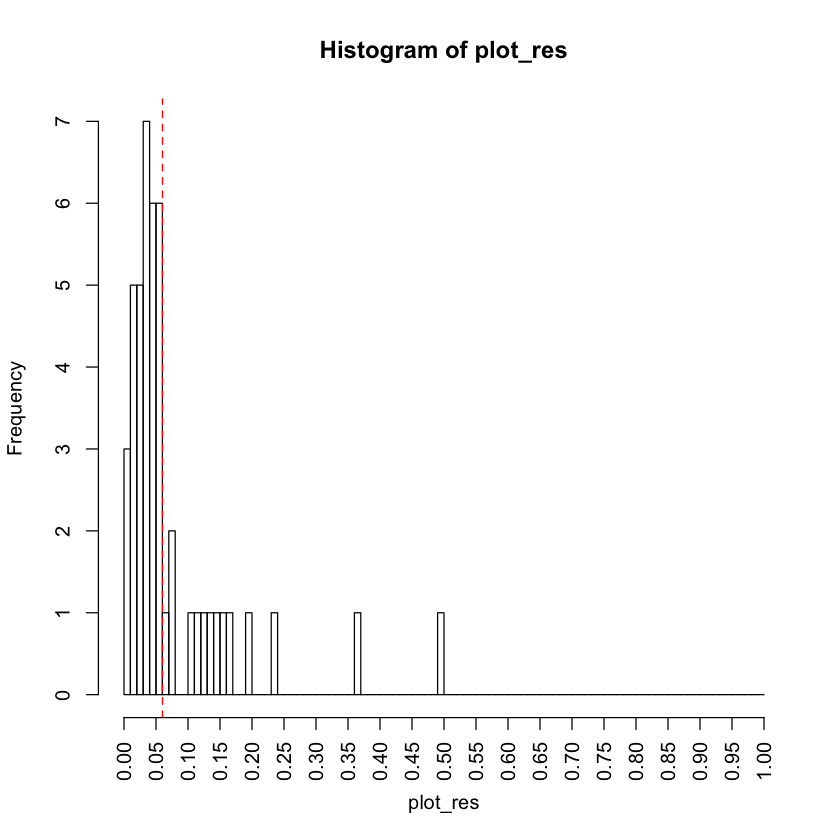

In [339]:
plot_res = c()
for(i in 1:length(sig_results)){
    if(length(sig_results[[i]]) > 1){
        n <- length(sig_results[[i]])
        plot_res <- c(plot_res,sort(sig_results[[i]],partial=n-1)[n-1])
    }
    else{
        plot_res <- c(plot_res, sig_results[[i]])
    }
}
breaks = seq(0,1,0.01)
hist(plot_res,breaks=breaks,xlim=range(breaks),xaxt="n")
axis(1, at = seq(0, 1, by = 0.05), las=2)
abline(v=0.06,col=2,lty=2)

In [341]:
save(sig_results, file='sig_res')

In [342]:
# After examination of distribution
sig_threshold <- 0.06 
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test:  age  and  hours.per.week"
[1] 0.07403111
[1] "-----------------"
[1] "test  education  and  hours.per.week given  occupation workclass"
[1] "occupation  =  5" "workclass  =  1" 
[1] 0.06275108
[1] "-----------------"
[1] "test  education  and  income given  hours.per.week occupation sex"
[1] "hours.per.week  =  1" "occupation  =  2"     "sex  =  1"           
[1] 0.1284068
[1] "hours.per.week  =  2" "occupation  =  2"     "sex  =  1"           
[1] 0.09366923
[1] "hours.per.week  =  3" "occupation  =  2"     "sex  =  1"           
[1] 0.1034253
[1] "hours.per.week  =  4" "occupation  =  2"     "sex  =  1"           
[1] 0.06778869
[1] "hours.per.week  =  5" "occupation  =  2"     "sex  =  1"           
[1] 0.1150442
[1] "hours.per.week  =  6" "occupation  =  2"     "sex  =  1"           
[1] 0.08453084
[1] "hours.per.week  =  1" "occupation  =  3"     "sex  =  1"           
[1] 0.1606985
[1] "hours.per.week  =  2" "occupation  =  3"     "sex  =  1"           
[1] 0.06605628

## Adjust Network

In [20]:
g <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
independencies <- impliedConditionalIndependencies( g )
print(independencies)
print(length(independencies))

age _||_ education
age _||_ occupation
age _||_ race
age _||_ sex
age _||_ workclass
education _||_ hours.per.week | occupation, sex, workclass
education _||_ marital.status
hours.per.week _||_ marital.status | age
hours.per.week _||_ race | education, sex
hours.per.week _||_ race | occupation, sex, workclass
income _||_ race | education, sex
income _||_ workclass | age, education, hours.per.week, occupation, sex
marital.status _||_ occupation
marital.status _||_ race
marital.status _||_ sex
marital.status _||_ workclass
occupation _||_ race | education, sex
occupation _||_ workclass | education
race _||_ sex
race _||_ workclass | education
sex _||_ workclass | education
[1] 21


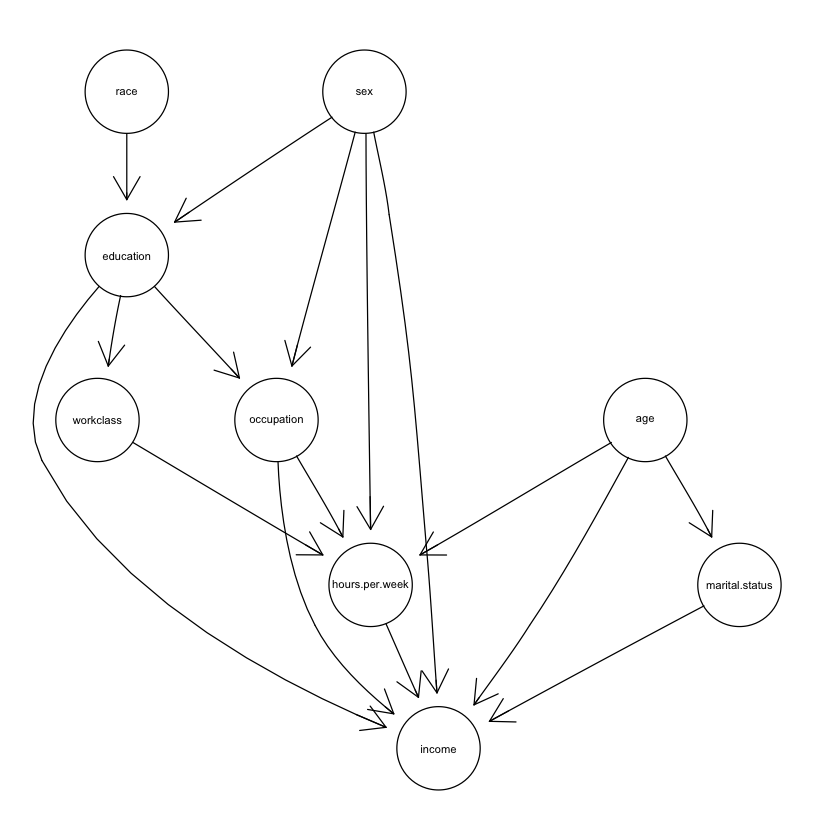

In [4]:
our_network <- dag(~ race + education:race:sex + workclass:education + hours.per.week:workclass:occupation:age:sex + occupation:education:sex + marital.status:age + income:age:sex:occupation:hours.per.week:education:marital.status)
plot(our_network)

In [345]:
## Re-test independencies
sig_results <- test_network(data, independencies, sig_threshold)

[1] "test  education  and  hours.per.week given  occupation sex workclass"
[1] "occupation  =  5" "sex  =  1"        "workclass  =  1" 
[1] 0.06327126
[1] "occupation  =  5" "sex  =  2"        "workclass  =  1" 
[1] 0.0682302
[1] "-----------------"
[1] "test  hours.per.week  and  marital.status given  age"
[1] "test  hours.per.week  and  race given  education sex"
[1] "education  =  1" "sex  =  2"      
[1] 0.06176595
[1] "-----------------"
[1] "test  hours.per.week  and  race given  occupation sex workclass"
[1] "test  income  and  race given  education sex"
[1] "test  income  and  workclass given  age education hours.per.week occupation sex"
[1] "age  =  8"            "education  =  1"      "hours.per.week  =  1"
[4] "occupation  =  1"     "sex  =  1"           
[1] 0.2405228
[1] "age  =  4"            "education  =  2"      "hours.per.week  =  1"
[4] "occupation  =  1"     "sex  =  1"           
[1] 0.09825749
[1] "age  =  7"            "education  =  2"      "hours.per.week  =  1

## Test influences

In [270]:
e_orig <- edges(g)[1:2]
edges(g)

v,w,e,x,y
age,hours.per.week,->,NA,NA
age,income,->,NA,NA
age,marital.status,->,NA,NA
education,income,->,NA,NA
education,occupation,->,NA,NA
education,workclass,->,NA,NA
hours.per.week,income,->,NA,NA
marital.status,income,->,NA,NA
occupation,hours.per.week,->,NA,NA
occupation,income,->,NA,NA


In [386]:
g1 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g2 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> marital.status; education -> income; marital.status -> income}" )
g3 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; education -> income; marital.status -> income}" )
g4 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; marital.status -> income}" )
g5 <- dagitty( "dag{race -> education; occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g6 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g7 <- dagitty( "dag{race -> education -> occupation -> hours.per.week; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g8 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income}" )
g9 <- dagitty( "dag{race -> education -> occupation; hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g10 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g11 <- dagitty( "dag{education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g12 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g13 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> occupation; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g14 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g15 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass -> hours.per.week; sex -> education; sex -> income; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )
g16 <- dagitty( "dag{race -> education -> occupation -> hours.per.week -> income; age -> hours.per.week; occupation -> income; education -> workclass; sex -> education; sex -> income; sex -> occupation; sex -> hours.per.week; age -> income; age -> marital.status; education -> income; marital.status -> income}" )

graphs = list(g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16)

edge_diffs = list(c('age','hours.per.week'),c('age','income'),c('age','marital.status'),c('education','income'), c('education','occupation'), c('education','workclass'), c('hours.per.week','income'), c('marital.status','income'), c('occupation','hours.per.week'), c('occupation','income'), c('race','education'), c('sex','education'), c('sex','hours.per.week'), c('sex','income'),c('sex','occupation'), c('workclass','hours.per.week'))

### Check all connections strengths by dropping the respective edge and calculating the RMSEA of the newly implied conditional independencies

In [388]:
res = c()
#Loop through all new graphs
for(i in 1:length(graphs)){
    e_diff <- edge_diffs[[i]]
    #get new implied independencies
    new_independencies <- impliedConditionalIndependencies(graphs[[i]])
    i_diff <- new_independencies[!(new_independencies %in% independencies)]
    if(length(i_diff) < 1){
        #Check if new implications found (not true if only edge to variable)
        res <- c(res,0)
        next
    }
    test_independencies <- c()
    #Test all new independencies
    for(j in 1:length(i_diff)){
        indp <- i_diff[j]
        xyz <- unlist(indp)
        if(is.null(xyz[1]) || is.null(xyz[2])){
            next
        }
        if(setequal(xyz[1:2], e_diff)){
            print(indp)
            test_independencies <- c(test_independencies, indp)
        }
    }
    res <- c(res,max(sapply(test_network(data, test_independencies, sig_threshold, T),sum)))
}


age _||_ hours.per.week
[1] "test:  age  and  hours.per.week"
[1] 0.07403111
[1] "-----------------"
[1] "Number of tests =  1"
[1] "Number of tested independencies =  1"
[1] "Number of failed independencies =  1"
age _||_ income | education, hours.per.week, marital.status, occupation, sex
age _||_ income | hours.per.week, marital.status, occupation, sex, workclass
[1] "test  age  and  income given  education hours.per.week marital.status occupation sex"
[1] "education  =  2"      "hours.per.week  =  1" "marital.status  =  1"
[4] "occupation  =  1"     "sex  =  1"           
[1] 0.09091062
[1] "education  =  3"      "hours.per.week  =  1" "marital.status  =  1"
[4] "occupation  =  1"     "sex  =  1"           
[1] 0.06259798
[1] "education  =  4"      "hours.per.week  =  1" "marital.status  =  1"
[4] "occupation  =  1"     "sex  =  1"           
[1] 0.2082483
[1] "education  =  2"      "hours.per.week  =  2" "marital.status  =  1"
[4] "occupation  =  1"     "sex  =  1"           
[1] 0

In [390]:
res

[1] 0.07403111 0.05889002 0.10107545 0.06188951 0.10658674 0.04294371
 [7] 0.05125881 0.14126575 0.04729136 0.07380976 0.00000000 0.02834162
[13] 0.07845953 0.11165523 0.14258123 0.04200558

In [ ]:
edge_diffs = list(c('age','hours.per.week'),c('age','income'),c('age','marital.status'),c('education','income'), c('education','occupation'), c('education','workclass'), c('hours.per.week','income'), c('marital.status','income'), c('occupation','hours.per.week'), c('occupation','income'), c('race','education'), c('sex','education'), c('sex','hours.per.week'), c('sex','income'),c('sex','occupation'), c('workclass','hours.per.week'))

## Strengths

|| Strength |
|:--- |
| ** Sex - Occupation ** | 0.143 |
| ** Martial Status - Income ** | 0.141 |
| ** Sex - Income ** | 0.112 |
| ** Education - Occupation ** | 0.107 |
| ** Age - Marital.status ** | 0.101 |
| ** Sex - Hours Per Week ** | 0.078 |
| ** Occupation - Income ** | 0.074 |
| ** Age - Hours Per Week ** | 0.074 |
| ** Education - Income ** | 0.062 |
| ** Age - Income ** | 0.059 |
| ** Hours Per Week - Income ** | 0.051 |
| ** Occupation - Hours Per Week ** | 0.047 |
| ** Education - Workclass ** | 0.043 |
| ** Workclass - Hours Per Week ** | 0.042 |
| ** Sex - Education ** | 0.028 |





## Inference

In [5]:
## Load deleted rows
del_data <- read.table(header=T, sep=",", 'adult_cleaned_deleted.csv')

del_data$native.country <- NULL
data$native.country <- NULL

In [24]:
# Create network object
net1 <- compile( grain( our_network, data, smooth=1 ) )
pp <- extractCPT( data, our_network, smooth=1)

### Missing values

In [7]:
head(del_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,NA,2,0,NA,1,0,5,1
2,NA,0,5,NA,0,0,3,0
1,NA,2,2,NA,0,0,3,0
5,NA,1,0,NA,0,0,0,0
0,NA,1,2,NA,0,1,2,0
2,NA,1,0,NA,0,0,3,0


In [8]:
predict <- function(data, var_names, verbose){
    new_data <- data
    for(i in 1:dim(data)[1]){
        row <- data[i,]
        given_names <- list()
        given_vals <- list()
        missing_names <- list()
        missing_idx <- list()
        g_idx <- 1
        m_idx <- 1
        for(j in 1:length(row)){
            if(is.na(row[[j]])){
                missing_names[[m_idx]] <- var_names[[j]]
                missing_idx[[m_idx]] <- j
                m_idx <- m_idx + 1
            } else {
                given_names[[g_idx]] <- var_names[[j]]
                given_vals[[g_idx]] <- toString(row[[j]])
                g_idx <- g_idx + 1
            }
        }
        net_ev <- setEvidence(net1, unlist(given_names, use.names=FALSE), unlist(given_vals, use.names=FALSE),propagate=TRUE)
        if(length(missing_names) > 0){
            for(j in 1:length(missing_names)){
                q <- querygrain(net_ev, nodes=missing_names[[j]],type = "marginal")
                if(verbose){
                    print(q)
                    print('Max at')
                    print(which.max(unlist(q, use.names=FALSE)))
                }
                for(a in 1:length(given_names)){
                    given_vals[[a]]
                }
                new_data[i,missing_idx[[j]]] <- which.max(unlist(q, use.names=FALSE)) - 1
            }
        }
        if(verbose){
            print('-----')        
        }
    }
    
    return(new_data)
}

In [9]:
verbose <- FALSE
var_names <- c('age','workclass','education','marital.status','occupation','race','sex','hours.per.week','income')
new_data <- predict(del_data, var_names, verbose)

It can be seen, that the missing values are successfully substituted with actual values.

In [10]:
head(new_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,0,2,0,0,1,0,5,1
2,0,0,5,1,0,0,3,0
1,0,2,2,1,0,0,3,0
5,0,1,0,1,0,0,0,0
0,0,1,2,0,0,1,2,0
2,0,1,0,1,0,0,3,0


In [403]:
head(del_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
4,NA,2,0,NA,1,0,5,1
2,NA,0,5,NA,0,0,3,0
1,NA,2,2,NA,0,0,3,0
5,NA,1,0,NA,0,0,0,0
0,NA,1,2,NA,0,1,2,0
2,NA,1,0,NA,0,0,3,0


In [11]:
# Save to be accessable for later
write.csv(new_data, file = "../adult_added_missing_vals.csv",row.names=FALSE)

### Test whether independencies are affected by added data

In [12]:
data1 <- read.table(header=T, sep=",", 'adult_cleaned.csv')
data2 <- read.table(header=T, sep=",", 'adult_added_missing_vals.csv')

In [16]:
data2$native.country <- NULL
total <- rbind(data1, data2) 

In [22]:
sig_threshold <- 0.06 
sig_results <- test_network(total, independencies, sig_threshold)

[1] "test  education  and  hours.per.week given  occupation sex workclass"
[1] "occupation  =  5" "sex  =  1"        "workclass  =  1" 
[1] 0.06306475
[1] "occupation  =  5" "sex  =  2"        "workclass  =  1" 
[1] 0.06968974
[1] "occupation  =  5" "sex  =  1"        "workclass  =  2" 
[1] 0.1283587
[1] "occupation  =  1" "sex  =  2"        "workclass  =  2" 
[1] 0.1930697
[1] "-----------------"
[1] "test  hours.per.week  and  marital.status given  age"
[1] "test  hours.per.week  and  race given  education sex"
[1] "test  hours.per.week  and  race given  occupation sex workclass"
[1] "occupation  =  2" "sex  =  2"        "workclass  =  2" 
[1] 0.07692299
[1] "-----------------"
[1] "test  income  and  race given  education sex"
[1] "test  income  and  workclass given  age education hours.per.week occupation sex"
[1] "age  =  7"            "education  =  1"      "hours.per.week  =  1"
[4] "occupation  =  1"     "sex  =  1"           
[1] 0.1055241
[1] "age  =  5"            "education

### Look at some relations

In [13]:
# Reload so only this part of script can be executed
our_network <- dag(~ race + education:race:sex + workclass:education + hours.per.week:workclass:occupation:age:sex + occupation:education:sex + marital.status:age + income:age:sex:occupation:hours.per.week:education:marital.status)
data1 <- read.table(header=T, sep=",", 'adult_cleaned.csv')
data2 <- read.table(header=T, sep=",", 'adult_added_missing_vals.csv')
data1$native.country <- NULL
data2$native.country <- NULL
all_data <- rbind(data1, data2) 

In [14]:
# Create network object with all data
net_all <- compile( grain( our_network, all_data, smooth=1 ) )

In [15]:
## Female query Education
print("Education given sex = Female")
net4 <- setEvidence(net_all, c("sex"), c("1"),propagate=TRUE)
q4 <- querygrain(net4, nodes='education',type = "marginal")
print(q4)
## Male query Education
print("Education given sex = Male")
net5 <- setEvidence(net_all, c("sex"), c("0"),propagate=TRUE)
q5 <- querygrain(net5, nodes='education',type = "marginal")
print(q5)

[1] "Education given sex = Female"
$education
education
          0           1           2           3           4           5 
0.028324324 0.489110700 0.413002979 0.051638636 0.009222246 0.008701115 

[1] "Education given sex = Male"
$education
education
         0          1          2          3          4          5 
0.04104662 0.49236433 0.37557661 0.05400751 0.02203166 0.01497328 



In [16]:
## Female query Income
print("Income given sex = Female")
net4 <- setEvidence(net_all, c("sex"), c("1"),propagate=TRUE)
q4 <- querygrain(net4, nodes='income',type = "marginal")
print(q4)
## Male query Income
print("Income given sex = Male")
net5 <- setEvidence(net_all, c("sex"), c("0"),propagate=TRUE)
q5 <- querygrain(net5, nodes='income',type = "marginal")
print(q5)

[1] "Income given sex = Female"
$income
income
        0         1 
0.7001086 0.2998914 

[1] "Income given sex = Male"
$income
income
        0         1 
0.6971658 0.3028342 



In [17]:
## Female query Income
print("Income = High")
net4 <- setEvidence(net_all, c("income"), c("1"),propagate=TRUE)
q4 <- querygrain(net4, nodes='sex',type = "marginal")
print(q4)
## Male query Income
print("Income = Low")
net5 <- setEvidence(net_all, c("income"), c("0"),propagate=TRUE)
q5 <- querygrain(net5, nodes='sex',type = "marginal")
print(q5)

[1] "Income = High"
$sex
sex
        0         1 
0.6713532 0.3286468 

[1] "Income = Low"
$sex
sex
       0        1 
0.668262 0.331738 



In [18]:
## Female query Occupation
print("Occupation given sex = Female")
net4 <- setEvidence(net_all, c("sex"), c("1"),propagate=TRUE)
q4 <- querygrain(net4, nodes='occupation',type = "marginal")
print(q4)
## Male query Occupation
print("Occupation given sex = Male")
net5 <- setEvidence(net_all, c("sex"), c("0"),propagate=TRUE)
q5 <- querygrain(net5, nodes='occupation',type = "marginal")
print(q5)

[1] "Occupation given sex = Female"
$occupation
occupation
          0           1           2           3           4           5 
0.342790799 0.124008909 0.238827411 0.173681524 0.003386833 0.117304523 

[1] "Occupation given sex = Male"
$occupation
occupation
          0           1           2           3           4           5 
0.189612726 0.424235409 0.140515595 0.132603064 0.003439767 0.109593440 



In [19]:
## Race query Education
print("Education given race = White")
net4 <- setEvidence(net_all, c("race"), c("0"),propagate=TRUE)
q4 <- querygrain(net4, nodes='education',type = "marginal")
print(q4)
## Race query Education
print("Education given race = Asian-Pac-Islander")
net5 <- setEvidence(net_all, c("race"), c("1"),propagate=TRUE)
q5 <- querygrain(net5, nodes='education',type = "marginal")
print(q5)
## Race query Education
print("Education given race = Amer-Indian-Eskimo")
net6 <- setEvidence(net_all, c("race"), c("2"),propagate=TRUE)
q6 <- querygrain(net6, nodes='education',type = "marginal")
print(q6)
## Race query Education
print("Education given race = Other")
net7 <- setEvidence(net_all, c("race"), c("3"),propagate=TRUE)
q7 <- querygrain(net7, nodes='education',type = "marginal")
print(q7)
## Race query Education
print("Education given race = Black")
net8 <- setEvidence(net_all, c("race"), c("4"),propagate=TRUE)
q8 <- querygrain(net8, nodes='education',type = "marginal")
print(q8)

[1] "Education given race = White"
$education
education
         0          1          2          3          4          5 
0.03585603 0.48525585 0.39210281 0.05529638 0.01827233 0.01321660 

[1] "Education given race = Asian-Pac-Islander"
$education
education
         0          1          2          3          4          5 
0.03987524 0.32991953 0.47462994 0.08584613 0.04102592 0.02870325 

[1] "Education given race = Amer-Indian-Eskimo"
$education
education
         0          1          2          3          4          5 
0.05305614 0.58773066 0.31100350 0.02145841 0.01205242 0.01469886 

[1] "Education given race = Other"
$education
education
         0          1          2          3          4          5 
0.15468098 0.47908885 0.29829457 0.03031604 0.02279309 0.01482648 

[1] "Education given race = Black"
$education
education
          0           1           2           3           4           5 
0.032692087 0.590119351 0.337700401 0.029084228 0.005945255 0.004458679 



In [20]:
## Race query Income
print("Income given race = White")
net4 <- setEvidence(net_all, c("race"), c("0"),propagate=TRUE)
q4 <- querygrain(net4, nodes='income',type = "marginal")
print(q4)
## Race query Income
print("Income given race = Asian-Pac-Islander")
net5 <- setEvidence(net_all, c("race"), c("1"),propagate=TRUE)
q5 <- querygrain(net5, nodes='income',type = "marginal")
print(q5)
## Race query Income
print("Income given race = Amer-Indian-Eskimo")
net6 <- setEvidence(net_all, c("race"), c("2"),propagate=TRUE)
q6 <- querygrain(net6, nodes='income',type = "marginal")
print(q6)
## Race query Income
print("Income given race = Other")
net7 <- setEvidence(net_all, c("race"), c("3"),propagate=TRUE)
q7 <- querygrain(net7, nodes='income',type = "marginal")
print(q7)
## Race query Income
print("Income given race = Black")
net8 <- setEvidence(net_all, c("race"), c("4"),propagate=TRUE)
q8 <- querygrain(net8, nodes='income',type = "marginal")
print(q8)

[1] "Income given race = White"
$income
income
        0         1 
0.6968497 0.3031503 

[1] "Income given race = Asian-Pac-Islander"
$income
income
        0         1 
0.6620286 0.3379714 

[1] "Income given race = Amer-Indian-Eskimo"
$income
income
       0        1 
0.719038 0.280962 

[1] "Income given race = Other"
$income
income
        0         1 
0.7094622 0.2905378 

[1] "Income given race = Black"
$income
income
        0         1 
0.7185643 0.2814357 



## Testing

### Load test data without rows with missing values

In [408]:
test_data <- read.table(header=T, sep=",", 'adult_test_cleaned.csv')
test_data$native.country <- NULL
head(test_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,1
3,0,2,0,1,4,0,3,1
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


### Predict Income

In [409]:
targets <- test_data$income
test_data$income <- NA
head(test_data)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,NA
2,0,1,0,1,0,0,4,NA
1,4,1,0,2,0,0,3,NA
3,0,2,0,1,4,0,3,NA
2,0,1,2,2,0,0,2,NA
5,1,4,0,3,0,0,2,NA


In [410]:
predicted <- predict(test_data, var_names, verbose)
head(predicted)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,0
3,0,2,0,1,4,0,3,0
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


### Print Accuracy

It can be seen that our network has a prediction accuracy of 81.8% - this is comparable to 83% reported in the literature for naive bayes classification

In [411]:
accuracy <- sum(targets == predicted$income)/(length(targets))
print(accuracy)

[1] 0.8177291


### Test on data including missing values

When the previously deleted rows are added, the classification performance increases to 83.1%.

In [412]:
test_data_missing <- read.table(header=T, sep=",", 'adult_test_cleaned_deleted.csv')
test_data_missing$native.country <- NULL
total <- rbind(test_data, test_data_missing) 
targets_missing = c(targets, test_data_missing$income)

#### Replace missing values with average value

In [413]:
total_replaced <- total
for(i in 1:(ncol(total)-1)){   
    total_replaced[is.na(total[,i]), i] <- names(which.max(table(total[,i])))
}

In [414]:
predicted <- predict(total_replaced, var_names, verbose)
head(predicted)
accuracy <- sum(targets_missing == predicted$income)/(length(targets_missing))
print(accuracy)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,0
3,0,2,0,1,4,0,3,0
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


[1] 0.8313986


#### Predict all missing values

In [415]:
predicted <- predict(total, var_names, verbose)
head(predicted)
accuracy <- sum(targets_missing == predicted$income)/(length(targets_missing))
print(accuracy)

age,workclass,education,marital.status,occupation,race,sex,hours.per.week,income
1,0,1,2,1,4,0,3,0
2,0,1,0,1,0,0,4,0
1,4,1,0,2,0,0,3,0
3,0,2,0,1,4,0,3,0
2,0,1,2,2,0,0,2,0
5,1,4,0,3,0,0,2,1


[1] 0.8313986
